# Epipolar Lines and Epipoles

We have 2 images of the Himalaya building with us, taken from different angles. We want to draw the epipolar lines in the second image, corresponding to the appropriate points in the first image, and vice versa. We also want to compute the location of the epipoles, without using the epipolar lines

As usual, we first load the libraries we would require.

In [1]:
import numpy as np
import cv2 as cv
from matplotlib import pyplot as plt

## Loading the given data
The fundamental matrix and the corresponding points in both the image frames are provided to us. We load them into our code as arrays. 

In [2]:
F = [[-1.29750186e-06 , 8.07894025e-07,  1.84071967e-03],
[3.54098411e-06,  1.05620725e-06, -8.90168709e-03],
[-3.29878312e-03,  5.14822628e-03,  1.00000000e+00]]

pts1 =  [ [381 ,402],
		 [452 ,497],
		 [671, 538],
		 [501, 254],
		 [506 ,381],
		 [474 ,440],
		 [471 ,537],
		 [498 ,364],
		 [706 ,319],
		 [635 ,367] ] 

pts2 =  [[390 ,346],
		 [439, 412],
		 [651 ,417],
		 [477 ,194],
		 [482 ,300],
		 [456 ,359],
		 [454 ,444],
		 [475 ,287],
		 [686 ,185],
		 [606 ,253] ] 

Converting them to numpy arrays, and then loading both the images of the Himalaya building:

In [3]:
pts1 = np.array(pts1)
pts2 = np.array(pts2)
F = np.array(F)
img1 = plt.imread("img1.jpg")
img2 = plt.imread("img2.jpg")
print(img1.shape)
print(pts1.shape)

(720, 1280, 3)
(10, 2)


## Coplanarity Equation
We know that the set of corresponding points along with the actual object form the epipolar plane. F is the fundamental matrix and x and x' are the locations of the corresponding points in the first and second image respectively. The coplanarity constraint says that, **x'<sup>T</sup>Fx = 0**

## Getting the epipolar lines corresponding to the first image
Now we have the points of the first image in pts1. Their corresponding points in image 2 will lie ON THE EPIPOLAR LINE. We can compute the equation of the epipolar line by using the inbuilt function `cv.computeCorrespondEpilines` also. However, we are going to compute it ourselves using the fundamentals of epipolar geometry.

From the coplanarity equation, we see that the equation of the epipolar line corresponding to points in image 1 is given by: **Fx=0** 

So to get all epipolar lines, we compute Fx, F is fundamental matrix and x is point in image 1.

In [4]:
print(F.shape)
print(pts1.shape)

(3, 3)
(10, 2)


We notice that the dimensions don't match, so we append ones to the pts1 array to make it 10x3. Then we compute the dot product Fx as 'lines1' i.e. the equation of the epipolar line of the points in image 1. 

In [5]:
ones = np.ones((10,1))
pts1_final = np.append(pts1, ones, axis=1)

lines1 = np.dot(F, pts1_final.transpose())
print(lines1.shape)

(3, 10)


F is **(3x3)** and pts1_final.T is **(3x10)**. So we get lines1 as a **(3x10)** matrix i.e lines1.T is a **(10x3)** matrix. 

Each row in lines1.T corresponds to the equation of the epipolar line of the points in pts1_final as a,b,c, which are the coefficients in the equation of a line: ax<sup>2</sup>+bx+c.

So essentially, we have lines1 as the equations of the epipolar lines corresponding to points in image1. Now, we similarly find lines2. 

## Getting the epipolar lines corresponding to the second image
Similarly, we compute the equations of the epipolar lines corresponding to the points in the second image. Exploiting the coplanarity constraint, we see that the equations of these lines would be given by: x<sup>T</sup>F = 0

In [6]:
ones = np.ones((10,1))
pts2_final = np.append(pts2, ones, axis=1)

lines2 = np.dot(pts2_final, F)

pts2_final is **(10x3)** (x<sup>T</sup>) and F is **(3x3)**. So we get lines2 as a **(10x3)** matrix. Again, just like lines1, each row in lines2 corresponds to the equation of the epipolar line of the points in pts2_final as a,b,c, which are the coefficients in the equation of a line: ax<sup>2</sup>+bx+c.

So essentially, we have lines2 as the equations of the epipolar lines corresponding to points in image2. 

## Drawing the Epipolar lines

Now we simply plot the epipolar lines. We plot lines1 in image 2, and lines2 in image 1. We write a function that takes the points and the corresponding epipolar lines as arguments and plots it onto the image.

In [7]:
def drawlines(img1,lines, pts):
    r,c,_ = img1.shape
    for r, pt1 in zip(lines, pts):
        color=(0,255,255)
        x0,y0 = map(int, [0, -r[2]/r[1] ])
        x1,y1 = map(int, [c, -(r[2]+r[0]*c)/r[1] ])
        img1 = cv.line(img1, (x0,y0), (x1,y1), color ,4)
        img1 = cv.circle(img1, tuple(pt1), 5, color, 5)
    return img1

Now we call this function for lines1:

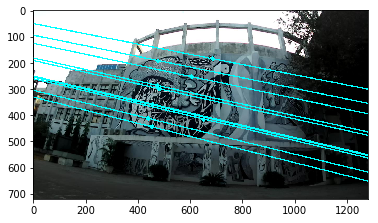

In [8]:
img3 = drawlines(img2, lines1.transpose(), pts2)
plt.imshow(img3)
plt.show()

And similarly, for lines2:

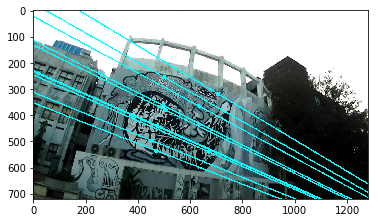

In [11]:
img4 = drawlines(img1, lines2, pts1)
plt.imshow(img4)
plt.show()

## Finding the Epipoles

All the epipolar lines will converge at the epipole. If we want to try to find the coordinates of the epipole without using the epipolar lines, we can make a good estimate from the fundamental matrix itself. 

Equation of epipolar lines of first image is Fx=0. For epipole of first image, we do a SVD decomposition of F to get UDV<sup>T</sup>. The last row of V<sup>T</sup> would correspond to the lowest eigenvalue, and that would be a good approximation of the epipole. 

In [12]:
u, d, v = np.linalg.svd(F, full_matrices=False)
print("Epipole of first image:", v[2,:])

Epipole of first image: [8.75919893e-01 4.82456398e-01 4.05675052e-04]


Equation of epipolar lines of second image is x<sup>T</sup>F=0. 

If we take whole transpose, we get F<sup>T</sup>x=0. So we do a SVD decomposition of F<sup>T</sup> to get UDV<sup>T</sup>. The last row of V<sup>T</sup> would correspond to the lowest eigenvalue, and that would be a good approximation of the epipole. 

In [13]:
u, d, v = np.linalg.svd(F.transpose(), full_matrices=False)
print("Epipole of second image:", v[2,:])

Epipole of second image: [-9.83333374e-01 -1.81811546e-01  1.91611592e-04]
